Parts of this has been pipeline has been implemented alongside https://github.com/zaidalyafeai/zaidalyafeai.github.io/blob/3523bffa1f876fd6d67fe599dfbe52570290df6d/sketcher/Sketcher.ipynb

# Beginning: Library and Module imports

Import Necessary Libraries.
There will be deviations within this notebook depending on the model trained and the imported dataset methods.


In [1]:
import PIL
import numpy
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

Mount the Google Drive. Feel free to edit the directory depending on your Google Drive structure, or directly upload the dataset to the runtime.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path = '/content/drive/MyDrive/Dissertation/Dataset_for_training'
test_path = '/content/drive/MyDrive/Dissertation/Dataset_for_testing/'

You can grab the individual .npy files for training and testing the model from the Google Cloud. https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap 

You'll need to put these inside of your drive. You can get an absolute path by using the file system window on the left-hand side of the page and right-clicking and copying the path. Change the relevant training and testing path. 

For locating the sketches within these files for later examination of specific sketches within the .npy files, you can grab batches of the ndjson files from kaggle (https://www.kaggle.com/datasets/google/tinyquickdraw) or from (https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/simplified), these are simplified and preprocessed.

In [4]:
!pip install ndjson
import ndjson
json_path = "/content/drive/MyDrive/Dissertation/ndjson/sword.ndjson"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
desired_sketch_strokes = 2

This script reads the json objects from within the ndjson files within the relevant path. Below is the explanation of variables.


*   json_path - location of ndjson file
*   desired_sketch_strokes - the number of strokes that make up a sketch
*   line_num - starts at 1, increments each loop. This is appended to the end of json_object, indicates which line it resides upon in the ndjson file
*   json_data - all the lines within the ndjson file
*   draw_array - the drawing representation (an array) pulled from the current json_object
*   json_object - the current line iterated on within the ndjson file
*   list_sketches - a list of numbers that reference the line number within the ndjson file that match the desired number of strokes within a sketch


In [6]:
def extract_sketch_line_nums(stroke_num):
  list_sketches = []
  line_num = 1
  with open (json_path) as jsonfile:
    json_data = ndjson.load(jsonfile)
    for json_object in json_data:
      draw_array = (json_object["drawing"])
      json_object['line'] = line_num
      line_num += 1
      if len(draw_array) == stroke_num:
        list_sketches.append(json_object['line'])
    return list_sketches

In [7]:
list_sketches = extract_sketch_line_nums(desired_sketch_strokes)
print(len(list_sketches))

22909


# Loading Functions


In [8]:
def load_files(max, files):

    #set x and y for test, shaped for the npy files (QuickDraw npy files are shaped x[image],[resolution (28, 28)] y is labels (based on class names))
    x = numpy.empty([0, 784])
    y = numpy.empty([0])
    classes = []

    #load each file into x and y
    for sketchx, file in enumerate(files):
        data = numpy.load(file)
        data = data[0: max, :]
        labels = numpy.full(data.shape[0], sketchx)
        x = numpy.concatenate((x, data), axis=0)
        y = numpy.append(y, labels)
        file_name, ext = os.path.splitext(os.path.basename(file))
        classes.append(file_name)  # add filenames to the back of list, remove the extension (.npy)
       
    #clear data and labels at the end of the loop
    data = None
    labels = None

    return y, x, classes

This should ONLY be called for the dataset used for training, testing and validation of the Convolutional Neural Network.

In [9]:
def data_init_network(data_path): 
    all_files = glob.glob(os.path.join(data_path, '*.npy'))
    validation_from_files=0.2
    max_sketch_per_class= 4000

    y, x, classes = load_files(max_sketch_per_class, all_files)
    
    #randomize the dataset using the permutations
    randomisation = numpy.random.permutation(y.shape[0])
    x = x[randomisation, :]
    y = y[randomisation]

    # we're using around 20% for spliting into test/training
    split_size = int(x.shape[0]/100*(validation_from_files*100))

    x_test = x[0:split_size, :]
    y_test = y[0:split_size]

    x_train = x[split_size:x.shape[0], :]
    y_train = y[split_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, classes

This may fail due to System RAM, try running it once or twice.

In [11]:
x_train, y_train, x_test, y_test, classes = data_init_network(train_path)

Now, load the data within the stroke-testing folder which will be used to specifically indentify the strokes, non-randomised with no classes extracted. You only need testing, there's no need for splitting this.

In [12]:
def data_init_strokes(path):
    stroke_files = glob.glob(os.path.join(path, '*.npy'))
    max_sketch_per_class= 8000
    y, x, classes = load_files(max_sketch_per_class, stroke_files)
    x_test = x[0:x.shape[0], :]
    y_test = y[0:x.shape[0]]

    return x_test, y_test

In [13]:
e_test, r_test = data_init_strokes(test_path)

In [15]:
print(classes)
print(x_train.shape)
print(e_test.shape) # should be num of test files x 8000
print(r_test.shape)
print("First part of the array is number of images, second number is the number of neurons required within input laye (after re-shaping)")

['full_numpy_bitmap_sweater', 'full_numpy_bitmap_swing set', 'full_numpy_bitmap_sword', 'full_numpy_bitmap_syringe', 'full_numpy_bitmap_t-shirt', 'full_numpy_bitmap_table', 'full_numpy_bitmap_teapot', 'full_numpy_bitmap_telephone', 'full_numpy_bitmap_television', 'full_numpy_bitmap_teddy-bear', 'full_numpy_bitmap_tent', 'full_numpy_bitmap_tiger', 'full_numpy_bitmap_tennis racquet', 'full_numpy_bitmap_toilet', 'full_numpy_bitmap_toaster', 'full_numpy_bitmap_tooth', 'full_numpy_bitmap_toe', 'full_numpy_bitmap_toothbrush', 'full_numpy_bitmap_toothpaste', 'full_numpy_bitmap_tractor', 'full_numpy_bitmap_train', 'full_numpy_bitmap_tornado', 'full_numpy_bitmap_traffic light', 'full_numpy_bitmap_triangle', 'full_numpy_bitmap_trombone', 'full_numpy_bitmap_tree', 'full_numpy_bitmap_truck', 'full_numpy_bitmap_umbrella', 'full_numpy_bitmap_underwear', 'full_numpy_bitmap_trumpet', 'full_numpy_bitmap_wine bottle', 'full_numpy_bitmap_windmill', 'full_numpy_bitmap_whale', 'full_numpy_bitmap_wheel', 'f

# User-created sketches

**SIDE NOTE SECTION:** 
Not neccessary. If you need to convert a drawing to the proper format that is also then more suitable for matching up with the training data, then the code below will let you. This will not work with this solution.

You can save this image for later use if desired.

In [29]:
from PIL import Image

filename = "/content/drive/MyDrive/Dissertation/User-created/3strokeflower.png"
sketch = Image.open(filename)
sketch.thumbnail((28,28), Image.ANTIALIAS)
resized = Image.new("1", (28,28), "white")
resized.paste(sketch, (int(((28,28)[0] - sketch.size[0]) / 2), int(((28,28)[1] - sketch.size[1]) / 2)))
resized.save(file_name, "PNG")
resized.show() # only use this sparingly and if you need to check individual images

Below code converts an image into an array, directly ready for use at prediction.

In [32]:
filename = "/content/drive/MyDrive/Dissertation/User-created 3strokeflower.png"
img = tf.keras.utils.load_img(filename, color_mode="grayscale", target_size=(28,28))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img.show()

# Re-shaping, pre-processing and normalisation

In [33]:
# shapes the npy files within train and test to (shape) 28, 28, 1
# these are representations of 1 bit deep images at 28,28 sizes (black and white)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
x_train /= 255.0
x_test /= 255.0

e_test = e_test.reshape(e_test.shape[0], 28, 28, 1).astype('float32')

e_test /= 255.0
# Here, we need to convert a class vector to binary class matrices
# Num of Files is referred to as classes, it will output the file associated as a class when predicting
numofFiles= len(classes)
y_train = keras.utils.to_categorical(y_train, numofFiles)
y_test = keras.utils.to_categorical(y_test, numofFiles)
print(x_train.shape)
print(x_test.shape)
print(e_test.shape)

(320000, 28, 28, 1)
(80000, 28, 28, 1)
(64000, 28, 28, 1)


# Model

Defining models. There will be two models tested. One from a basic Sequential Convolutional Neural Network. Last layer must be softmax, this is not a binary classification problem.

In [34]:
# Define model
conrad = keras.Sequential()
conrad.add(layers.Convolution2D(16, (3, 3),  padding='same', input_shape=x_train.shape[1:], activation='relu'))
conrad.add(layers.MaxPooling2D(pool_size=(2, 2)))
#conrad.add(layers.Convolution2D(16, (3, 3),  padding='same', input_shape=x_train.shape[1:], activation='relu')) # [1:] everything after the first index of x.shape
conrad.add(layers.Convolution2D(32, (3, 3),  padding='same', activation='relu'))
conrad.add(layers.MaxPooling2D(pool_size=(2, 2)))
conrad.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
conrad.add(layers.MaxPooling2D(pool_size=(2, 2)))
conrad.add(layers.Convolution2D(128, (3, 3), padding='same', activation= 'relu'))
conrad.add(layers.MaxPooling2D(pool_size =(2,2)))
conrad.add(layers.Flatten())
conrad.add(layers.Dense(128, activation='relu'))  
conrad.add(layers.Dense(numofFiles, activation='softmax'))  # non-binary classification
# Train model
adam = tf.optimizers.Adam()
conrad.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(conrad.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [35]:
conrad.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 128, verbose=2, epochs=10)

Epoch 1/10
2250/2250 - 21s - loss: 2.0054 - accuracy: 0.4993 - val_loss: 1.4964 - val_accuracy: 0.6173 - 21s/epoch - 9ms/step
Epoch 2/10
2250/2250 - 9s - loss: 1.3495 - accuracy: 0.6512 - val_loss: 1.2663 - val_accuracy: 0.6705 - 9s/epoch - 4ms/step
Epoch 3/10
2250/2250 - 9s - loss: 1.1922 - accuracy: 0.6893 - val_loss: 1.1971 - val_accuracy: 0.6903 - 9s/epoch - 4ms/step
Epoch 4/10
2250/2250 - 10s - loss: 1.1025 - accuracy: 0.7103 - val_loss: 1.1343 - val_accuracy: 0.7052 - 10s/epoch - 4ms/step
Epoch 5/10
2250/2250 - 9s - loss: 1.0421 - accuracy: 0.7260 - val_loss: 1.0875 - val_accuracy: 0.7173 - 9s/epoch - 4ms/step
Epoch 6/10
2250/2250 - 10s - loss: 0.9968 - accuracy: 0.7361 - val_loss: 1.0730 - val_accuracy: 0.7213 - 10s/epoch - 4ms/step
Epoch 7/10
2250/2250 - 10s - loss: 0.9578 - accuracy: 0.7450 - val_loss: 1.0694 - val_accuracy: 0.7187 - 10s/epoch - 4ms/step
Epoch 8/10
2250/2250 - 10s - loss: 0.9291 - accuracy: 0.7516 - val_loss: 1.0427 - val_accuracy: 0.7282 - 10s/epoch - 5ms/ste

In [36]:
score = conrad.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))
print('Loss value: {:0.2f}'.format(score[0]))

Test accuarcy: 73.16%
Loss value: 1.04


In [ ]:
del score # clears up some memory

# Individual Sketch prediction

For using the sketch-testing dataset, the below code will search for the index of the array. This is for individual testing of sketches. Unless you use a value above 4000, this has the potential to be the same data used within the training and testing of the model. Upon passing 8000, it should no longer be used.

In [37]:
print(list_sketches[0])
# This is the line within the NDJSON file. 
# As each object has a total of 8000, it should be noted that when passing 8000 lines, you have moved to a new class
# For example, "Clock" sketches  may exist between 1-8000, then begins a new object, etc.

5


5
1/1 [==============================] - 0s 18ms/step
['full_numpy_bitmap_sword', 'full_numpy_bitmap_chandelier', 'full_numpy_bitmap_syringe', 'full_numpy_bitmap_flashlight', 'full_numpy_bitmap_floor lamp']
0.93
0.02
0.01
0.01
0.01


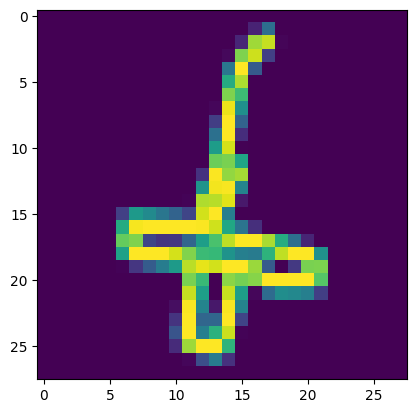

In [40]:
%matplotlib inline
uid = list_sketches[0]
print(uid)
sketch = e_test[uid]
plt.imshow(sketch.squeeze()) 
pred = conrad.predict(numpy.expand_dims(sketch, axis=0))[0]
indices_array = (-pred).argsort()[:5]
sketch_prediction = [classes[x] for x in indices_array]
print(sketch_prediction)
#round to 2 decimal places
print("%.2f" % round(pred[indices_array[0]], 2))
print("%.2f" % round(pred[indices_array[1]], 2))
print("%.2f" % round(pred[indices_array[2]], 2))
print("%.2f" % round(pred[indices_array[3]], 2))
print("%.2f" % round(pred[indices_array[4]], 2))

In [43]:
conrad.save('/content/drive/MyDrive/Dissertation/CONRAD')